# Test of PCA in Pipeline For Training Models
### Leonard Moen | December 5th 2022

In [32]:
import pandas as pd
import numpy as np
import importlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
# import lazypredict

# from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import  Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize #Standardization and conversion of categorical labels to binary representation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

import LoadKinecalFunctions
from LoadKinecalFunctions import *
importlib.reload(LoadKinecalFunctions)
from const import User, Exercise
import models
from models import *
importlib.reload(models)
importlib.reload(sklearn.linear_model)

<module 'sklearn.linear_model' from 'c:\\Users\\Leonard\\anaconda3\\envs\\ELEC872\\lib\\site-packages\\sklearn\\linear_model\\__init__.py'>

In [33]:
user = 0
excerciseList = [Exercise.QSECFS, Exercise.QSEOFS, Exercise.STS, Exercise.TS]

QSClosedDf = readKinecalFiles(excerciseList[0],user) 
QSOpenDf = readKinecalFiles(excerciseList[1],user) 
SemiTandemDf = readKinecalFiles(excerciseList[2],user) 
TandemDf = readKinecalFiles(excerciseList[3],user) 

### Seperate X and Y Dataframes

In [34]:
yDf = QSClosedDf.iloc[:,0:9]
yDf = yDf.drop(columns='movement')

QSClosedXDf =QSClosedDf.iloc[: ,9:-1]
QSOpenXDf =QSOpenDf.iloc[: ,9:-1]
SemiTandemXDf =SemiTandemDf.iloc[: ,9:-1]
TandemXDf =TandemDf.iloc[: ,9:-1]

print(yDf)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
0       10    HA   m    1.85    77.0  22.5                   1   
1      100    NF   f    1.55    82.5  34.3                   1   
2       11    HA   f    1.57    51.5  20.9                   1   
3       12    HA   m    1.64    68.5  25.5                   1   
4       13    HA   m    1.78    85.0  26.8                   1   
..     ...   ...  ..     ...     ...   ...                 ...   
85      84   FHm   f    1.56    60.0  24.7                   0   
86      87   FHs   f    1.60    77.1  30.1                   0   
87       9    HA   m    1.69    75.0  26.3                   1   
88      92    NF   m    1.83    97.0  29.0                   0   
89      96   FHs   m    1.78    81.2  25.6                   0   

   clinically_at_risk  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
85                  0  
86             

### Replace Missing Values

In [35]:
QSClosedXDf = replaceMissingValues(QSClosedXDf,yDf)
QSOpenXDf = replaceMissingValues(QSOpenXDf,yDf)
SemiTandemXDf = replaceMissingValues(SemiTandemXDf,yDf)
TandemXDf = replaceMissingValues(TandemXDf,yDf)

[ 2 14 15]
[ 2 17 29 34 71]
[ 2 14 17 31 33 60 66]
[13 14 17 29 31 33 36 37 55 60 66 74 77]


### Perform Sample Normallization

In [36]:
#print(np.asarray(QS_Closed_x_df.iloc[0,:].values))
QSClosedXNormDf = datasetNormalization(QSClosedXDf)
QSOpenXNormDf = datasetNormalization(QSOpenXDf)
SemiTandemXNormDf = datasetNormalization(SemiTandemXDf)
TandemXNormDf = datasetNormalization(TandemXDf)

### Combine Excercises Into One Dataset

In [37]:
print(QSClosedXNormDf.shape,QSOpenXNormDf.shape,SemiTandemXNormDf.shape,TandemXNormDf.shape)
combinedXNormDf = pd.concat([QSClosedXNormDf,QSOpenXNormDf,SemiTandemXNormDf,TandemXDf],axis=1)
print(combinedXNormDf.shape)

(90, 16) (90, 16) (90, 16) (90, 16)
(90, 64)


### Add Labels for Binary Case

In [38]:
yTrain = binaryLabelRemapping(yDf,True)

### Seperate Into Training and Testing Sets

In [39]:
xTrain, xTest, yTrain, yTest = train_test_split(combinedXNormDf, yDf, test_size=0.2, random_state=42)

le = LabelEncoder()

yTrainBinary = binaryLabelRemapping(yTrain, True)
yTestBinary = binaryLabelRemapping(yTest, True)

yTrain_bin_orig = yTrainBinary
yTest_bin_orig = yTestBinary

yDf_bin = binaryLabelRemapping(yDf, True)

X = np.asarray(combinedXNormDf)
y_bin = np.asarray(le.fit_transform(yDf_bin.label_binary.values))

#convert to numpy array
yTrainBinary = np.asarray(le.fit_transform(yTrainBinary.label_binary.values))
yTestBinary = np.asarray(le.fit_transform(yTestBinary.label_binary.values))

### Tune Perceptron

In [40]:
#Perform grid search on best model
tuning_params = [{
    "penalty": ['elasticnet'],
    "alpha": [0.09, 0.1, 0.11],
    "l1_ratio": [0.48, 0.49, 0.5, 0.51, 0.52],
    "tol": [5e-6],
    "eta0": [6e-5, 1e-4, 1e-3],
    "early_stopping": [False],
    "class_weight": [None],
    "warm_start": [True],
    "fit_intercept": [False, True]
}]

log = []
for num_components in range(1,64): # Iterate through the use of 3 to 100 components  (3,101)

    pca = PCA(n_components=num_components) # Initialize a PLS object, specifying 10 components
    #pls = LinearDiscriminantAnalysis(n_components=num_components)
    pca.fit(X, y_bin) # Fit to the training data w/ binary label set
    #transformed_pls_data = pls.x_scores_ # Extract the computed components on the training data

    pca_X = pca.transform(X)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(Perceptron(), tuning_params, 
                        cv=skf.split(pca_X,y_bin), scoring='accuracy', 
                        verbose=2, refit=True)

    grid.fit(pca_X,y_bin)
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        log += [{'num_components': num_components, 'mean': mean, 'std': std, 'params': params}]

# best_model = grid.best_estimator_
# optimal_params = grid.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END alpha=0.09, class_weight=None, early_stopping=False, eta0=6e-05, fit_intercept=False, l1_ratio=0.48, penalty=elasticnet, tol=5e-06, warm_start=True; total time=   0.0s
[CV] END alpha=0.09, class_weight=None, early_stopping=False, eta0=6e-05, fit_intercept=False, l1_ratio=0.48, penalty=elasticnet, tol=5e-06, warm_start=True; total time=   0.0s
[CV] END alpha=0.09, class_weight=None, early_stopping=False, eta0=6e-05, fit_intercept=False, l1_ratio=0.48, penalty=elasticnet, tol=5e-06, warm_start=True; total time=   0.0s
[CV] END alpha=0.09, class_weight=None, early_stopping=False, eta0=6e-05, fit_intercept=False, l1_ratio=0.48, penalty=elasticnet, tol=5e-06, warm_start=True; total time=   0.0s
[CV] END alpha=0.09, class_weight=None, early_stopping=False, eta0=6e-05, fit_intercept=False, l1_ratio=0.48, penalty=elasticnet, tol=5e-06, warm_start=True; total time=   0.0s
[CV] END alpha=0.09, class_weight=None, early_stoppin

In [44]:
# print(grid.best_score_)
# print(grid.best_params_)

grid_log_df = pd.DataFrame(log)
grid_log_df.sort_values(['mean'], ascending=False).iloc[0:10]


num_components      mean       std  \
109                2  0.744444  0.044444   
99                 2  0.744444  0.044444   
365                5  0.711111  0.054433   
375                5  0.711111  0.054433   
89                 1  0.711111  0.054433   
329                4  0.711111  0.113312   
465                6  0.700000  0.103040   
455                6  0.700000  0.103040   
597                7  0.700000  0.103040   
3557              40  0.688889  0.124722   

                                                 params  
109   {'alpha': 0.09, 'class_weight': None, 'early_s...  
99    {'alpha': 0.09, 'class_weight': None, 'early_s...  
365   {'alpha': 0.09, 'class_weight': None, 'early_s...  
375   {'alpha': 0.09, 'class_weight': None, 'early_s...  
89    {'alpha': 0.11, 'class_weight': None, 'early_s...  
329   {'alpha': 0.1, 'class_weight': None, 'early_st...  
465   {'alpha': 0.09, 'class_weight': None, 'early_s...  
455   {'alpha': 0.09, 'class_weight': None, 'early_s...  
597   {'alpha': 0.1, 'class_weight': None, 'early_st...  
3557  {'alpha': 0.1, 'class_weight': None, 'early_st...

In [45]:
print(grid_log_df.iloc[0,3])

{'alpha': 0.09, 'class_weight': None, 'early_stopping': False, 'eta0': 6e-05, 'fit_intercept': False, 'l1_ratio': 0.48, 'penalty': 'elasticnet', 'tol': 5e-06, 'warm_start': True}


In [46]:
pca = PCA(n_components=2) # Initialize a PLS object, specifying 10 components (94 - pre low conc )
pca.fit(X, y_bin) # Fit to the training data w/ binary label set
pca_X = pca.transform(X)

best_model = Perceptron(alpha=0.09,eta0=6e-05,l1_ratio=0.48,penalty='elasticnet',tol=5e-06,warm_start=True, fit_intercept=False)
clf=best_model.fit(pca_X,y_bin)

# clf = best_model
pca_xTest = pca.transform(xTest)
y_pred = clf.predict(pca_xTest)

#map predictions back to original labels
y_pred_label = le.inverse_transform(y_pred)
y_test_label = le.inverse_transform(yTestBinary)

c:\Users\Leonard\anaconda3\envs\ELEC872\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


### Create Confusion Matrix and Classification Report

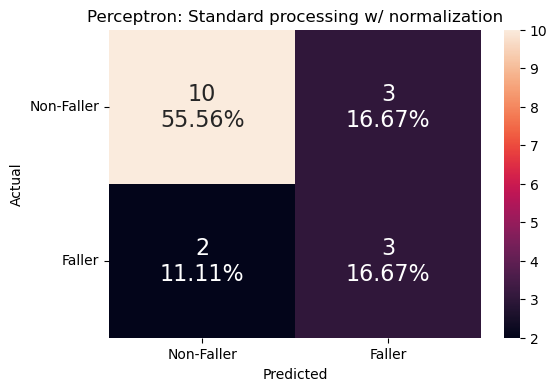

              precision    recall  f1-score   support

      Faller       0.50      0.60      0.55         5
  Non-Faller       0.83      0.77      0.80        13

    accuracy                           0.72        18
   macro avg       0.67      0.68      0.67        18
weighted avg       0.74      0.72      0.73        18



In [47]:
classes = ['Non-Faller', 'Faller']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Perceptron: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))